# Inverse Compton Scattering

In this notebook, we demonstrate the full inverse Compton scattering code, which converts an initial primary electron input to a final, fully resolved secondary photon spectrum. 

## Initialization

In [22]:
%load_ext autoreload
import sys
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]


from astropy.io import fits

import numpy as np
import pickle
import darkhistory.physics as phys
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
from darkhistory.spec.spectrum import Spectrum
import darkhistory.history.tla as tla

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.ics.ics_cooling import get_ics_cooling_tf

np.set_printoptions(threshold=np.nan)

## Reference Data

In [24]:
mwimp = 1e12
neng = 500
dlneng = np.log(mwimp)/neng
elecbins = np.exp(np.arange(neng+1)*dlneng)
englow = elecbins[0:neng]
enghigh = elecbins[1:]
eleceng_ref = np.sqrt(englow*enghigh)

nphoteng = 500
dlnphoteng = np.log(mwimp/1e-2)/nphoteng
photenglow = 1e-2*np.exp(np.arange(nphoteng)*dlnphoteng)
photenghigh = 1e-2*np.exp((np.arange(nphoteng)+1)*dlnphoteng)
photeng_ref = np.sqrt(photenglow*photenghigh)

ICS_test_filename = "/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_test.fits"
ICS_test = fits.open(ICS_test_filename)
ICS_test_spec = np.transpose(ICS_test_spec)
ICS_test_list_spec = [Spectrum(photeng_ref, arr, in_eng=in_eng) for (arr, in_eng) in zip(ICS_test_spec, eleceng_ref)]
ICS_test_tf = tf.TransFuncAtRedshift(ICS_test_list_spec, dlnz=-1)

## Inputs

First, we initialize the input to the ICS code. This is some spectrum of electrons and positrons (which have a similar ICS cooling behavior to electrons at high energies) at some redshift.

In [25]:
eleceng = eleceng_ref
photeng = photeng_ref

rs = 1000

elec_spec_init = spectools.rebin_N_arr(np.array([1]), 
                                      np.array([1e11]),
                                      eleceng)

elec_spec_init.rs = rs

## ICS Reference Files

Next, we load the pre-computed ICS transfer functions. The functions that are used to calculate these spectra are available as part of this code package, so calculating these results from scratch is also possible.

There are 3 transfer functions that we need to have: the transfer function to produce a photon spectrum as a result of a *single* scattering of a non-relativistic electron (`raw_nonrel_ICS_tf`), the same transfer function for a relativistic electron (`raw_rel_ICS_tf`), and finally a transfer function to get the energy lost by the electron after a single scatter (`raw_engloss_tf`). 

In [26]:
user="hongwan"
raw_nonrel_ICS_tf = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/ICS_nonrel.raw","rb"))
raw_rel_ICS_tf = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/ICS_rel.raw","rb"))
raw_engloss_tf = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/ICS_englossspec.raw","rb"))

## Full ICS Transfer Function

With these single-scattering transfer functions, we can now compute the full transfer function, which takes injected electrons through its complete cooling process, and produces a final secondary photon spectrum and low energy (sub 3 keV) electron spectrum. This is computed through the function `electrons.ics.ics_cooling.get_ics_cooling_tf()`. 

In [27]:
(ics_phot_tf, ics_lowengelec_tf) = get_ics_cooling_tf(raw_nonrel_ICS_tf,
                                                     raw_rel_ICS_tf,
                                                     raw_engloss_tf,
                                                     eleceng, photeng, rs)

Check that the result makes sense, relative to the reference data. In order to ensure an exact comparison, Be sure to use exactly the same electron and photon energy abscissa, as well as a redshift of 1000. The abscissa of the reference data is:

```python
mwimp = 1e12
neng = 500
dlneng = np.log(mwimp)/neng
elecbins = np.exp(np.arange(neng+1)*dlneng)
englow = elecbins[0:neng]
enghigh = elecbins[1:]
eleceng_ref = np.sqrt(englow*enghigh)

nphoteng = 500
dlnphoteng = np.log(mwimp/1e-2)/nphoteng
photenglow = 1e-2*np.exp(np.arange(nphoteng)*dlnphoteng)
photenghigh = 1e-2*np.exp((np.arange(nphoteng)+1)*dlnphoteng)
photeng_ref = np.sqrt(photenglow*photenghigh)
```

[0.0001, 10000000000000.0, 1e-16, 10000000000.0]

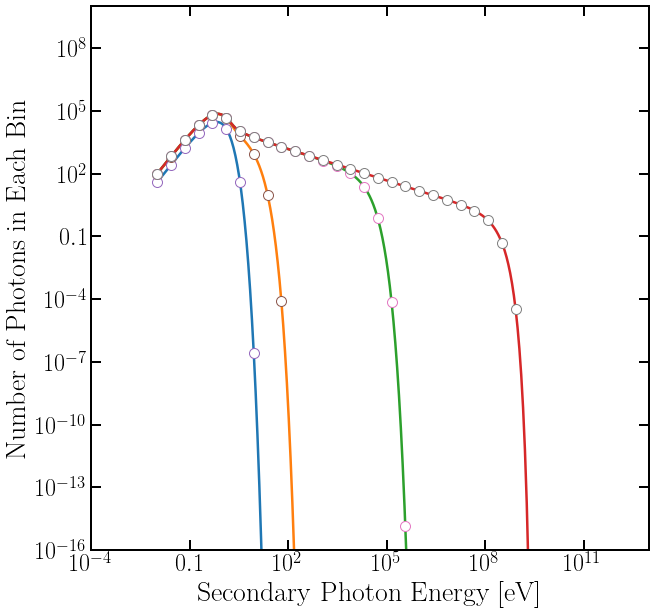

In [28]:
plt.figure()

ax = plt.gca()
comp_elec_kineng = np.array([3.5e3, 5e5, 5e7, 5e9])
ics_phot_tf.plot(ax, ind=comp_elec_kineng, indtype='in_eng')
ICS_test_tf.plot(
    ax, ind=comp_elec_kineng, indtype='in_eng', 
    linewidth=0, marker='o', markersize='10', 
    markerfacecolor='w', markevery=15,
)

ax.set_xscale('log')
ax.set_yscale('log')

plt.xlabel('Secondary Photon Energy [eV]')
plt.ylabel('Number of Photons in Each Bin')
plt.axis([1e-4, 1e13, 1e-16, 1e10])


## Applying the Transfer Functions

Now, scatter the initial photons through the full ICS transfer function. This is easily accomplished using the function `spec.spectools.scatter()`. This function takes in a transfer function, and applies it to an initial spectrum, producing the final spectrum after the scattering. The transfer function `spec_type` determines whether the transfer function acts as a map of number of particles to number of particles in each bin, or $dN/dE$ to $dN/dE$ in each bin. The `spec_type` of the input spectrum will be switched automatically based on this within the function, and the output has the same `spec_type` as the input. 

In [29]:
phot_spec_init = spectools.scatter(ics_phot_tf, elec_spec_init, new_eng=photeng)